In [1]:
import xarray as xr

ds_z500 = xr.open_dataset("../data/raw/era5_z500_2p5_2010_2019_DJF_6hour.nc")
ds_z500

<xarray.Dataset> Size: 52MB
Dimensions:         (valid_time: 3608, pressure_level: 1, latitude: 25,
                     longitude: 144)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 29kB 2010-01-01 ... 2019-12-3...
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 200B 80.0 77.5 75.0 ... 25.0 22.5 20.0
  * longitude       (longitude) float64 1kB -180.0 -177.5 -175.0 ... 175.0 177.5
    expver          (valid_time) <U4 58kB ...
Data variables:
    z               (valid_time, pressure_level, latitude, longitude) float32 52MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-12T01:35 GRIB to CDM+CF via cfgrib-0.9.1...

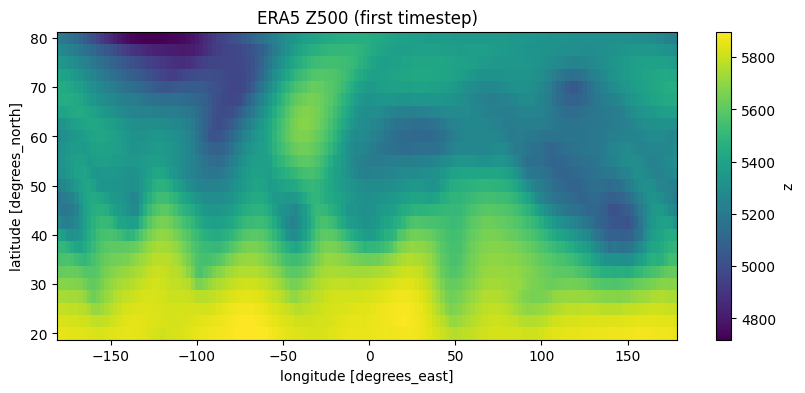

In [2]:
import matplotlib.pyplot as plt

da_z500 = ds_z500["z"].sel(pressure_level=500).isel(valid_time=0) / 9.81

plt.figure(figsize=(10,4))
da_z500.plot()
plt.title("ERA5 Z500 (first timestep)")
plt.show()


In [3]:
z500 = (ds_z500["z"].sel(pressure_level=500) / 9.81)
print(z500.min().item(), z500.max().item())

4567.35595703125 5983.658203125


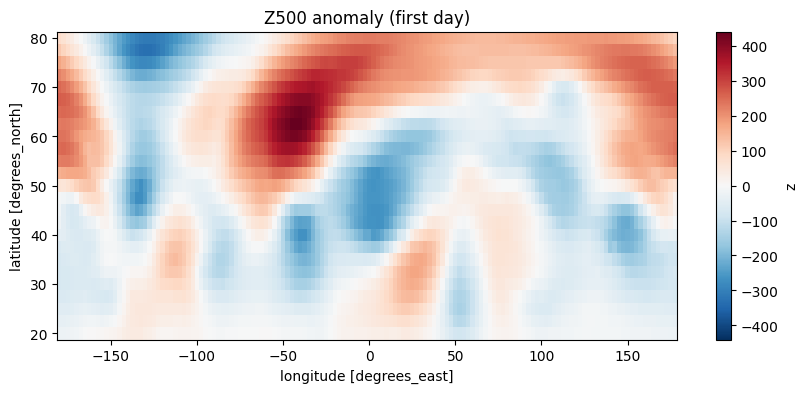

In [4]:
# daily mean
z500_daily = (
    ds_z500["z"]
    .sel(pressure_level=500)
    .resample(valid_time="1D")
    .mean()
    / 9.81
)


# climatology
clim = z500_daily.groupby("valid_time.dayofyear").mean("valid_time")

# anomaly
z500_anom = z500_daily.groupby("valid_time.dayofyear") - clim
da = z500_anom.isel(valid_time=0)

plt.figure(figsize=(10,4))
da.plot(cmap="RdBu_r")
plt.title("Z500 anomaly (first day)")
plt.show()

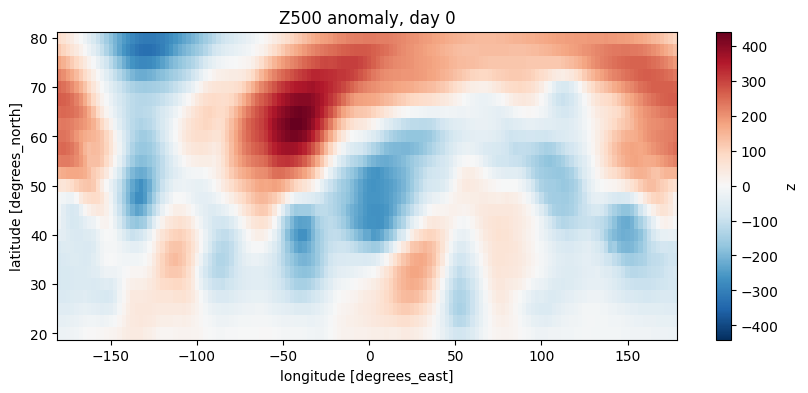

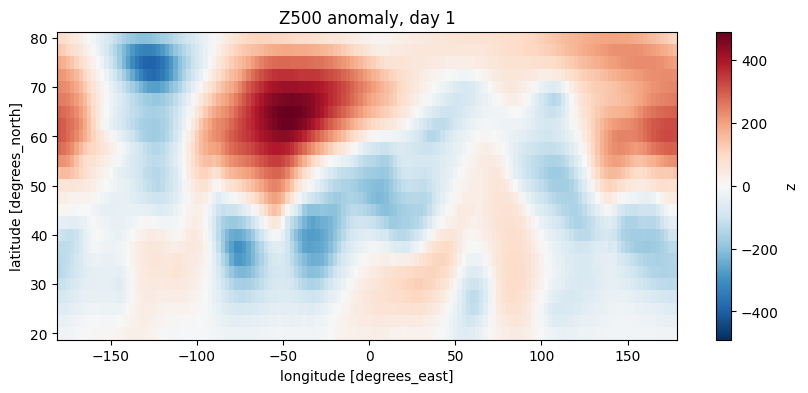

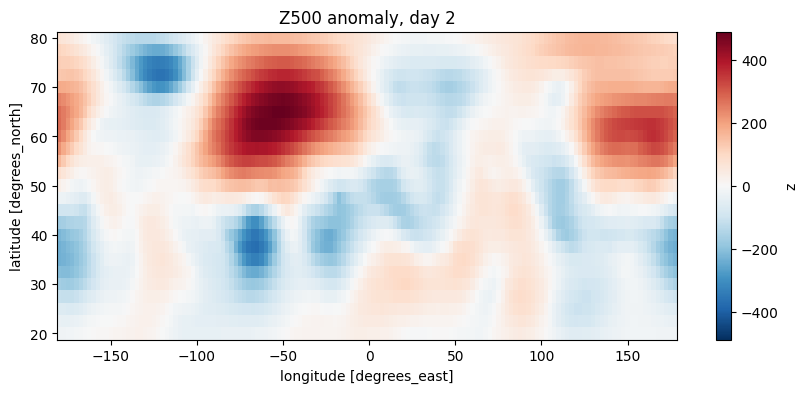

In [5]:
for i in range(3):
    plt.figure(figsize=(10,4))
    z500_anom.isel(valid_time=i).plot(
        cmap="RdBu_r"
    )
    plt.title(f"Z500 anomaly, day {i}")
    plt.show()

In [6]:
ds_t2m = xr.open_dataset("../data/raw/era5_t2m_2p5_2010_2019_DJF_6hour.nc")
ds_t2m

<xarray.Dataset> Size: 52MB
Dimensions:     (valid_time: 3608, latitude: 25, longitude: 144)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 29kB 2010-01-01 ... 2019-12-31T18...
  * latitude    (latitude) float64 200B 80.0 77.5 75.0 72.5 ... 25.0 22.5 20.0
  * longitude   (longitude) float64 1kB -180.0 -177.5 -175.0 ... 175.0 177.5
    expver      (valid_time) <U4 58kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 52MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-12T01:49 GRIB to CDM+CF via cfgrib-0.9.1...

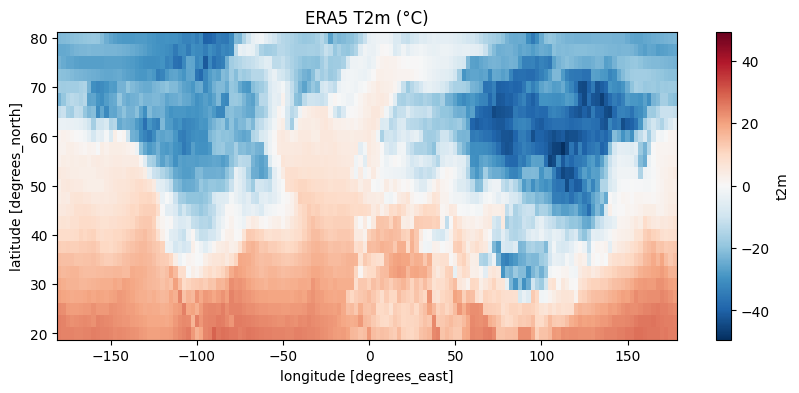

In [7]:
t2m = ds_t2m["t2m"] - 273.15  # K → °C

plt.figure(figsize=(10,4))
t2m.isel(valid_time=0).plot()
plt.title("ERA5 T2m (°C)")
plt.show()

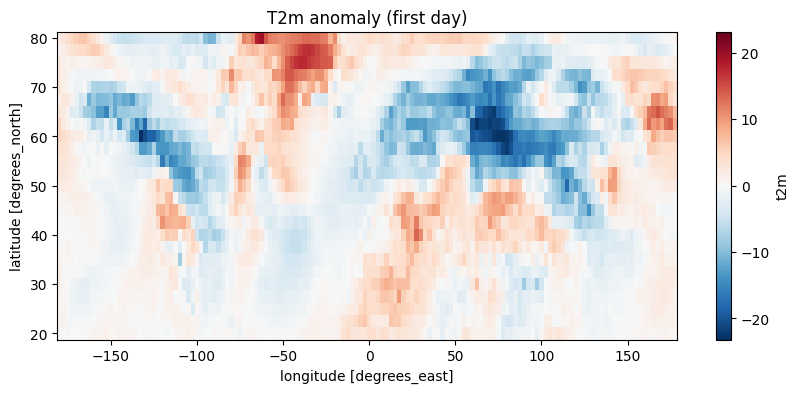

In [8]:
# daily mean
t2m_daily = (
    ds_t2m["t2m"]
    .resample(valid_time="1D")
    .mean()
    - 273.15
)

# climatology
clim = t2m_daily.groupby("valid_time.dayofyear").mean("valid_time")
# anomaly
t2m_anom = t2m_daily.groupby("valid_time.dayofyear") - clim


da = t2m_anom.isel(valid_time=0)

plt.figure(figsize=(10,4))
da.plot(cmap="RdBu_r")
plt.title("T2m anomaly (first day)")
plt.show()

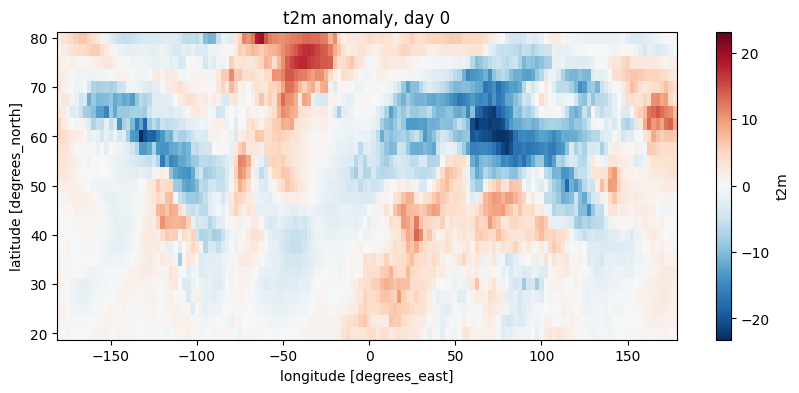

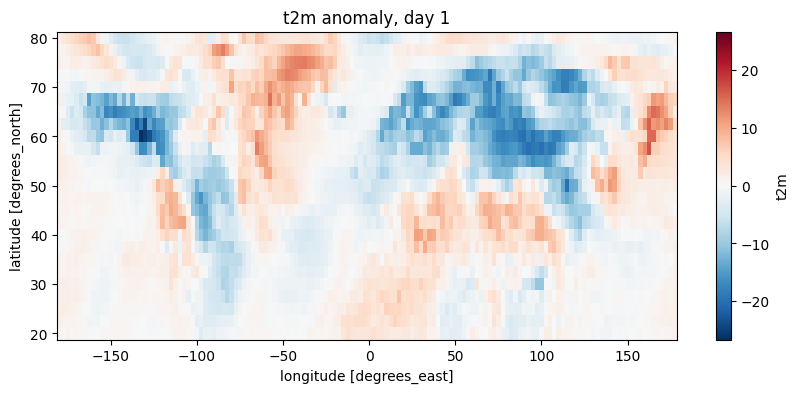

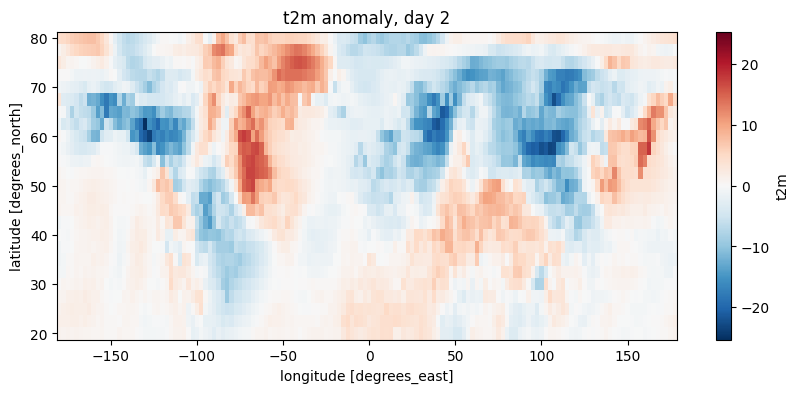

In [9]:
for i in range(3):
    plt.figure(figsize=(10,4))
    t2m_anom.isel(valid_time=i).plot(
        cmap="RdBu_r"
    )
    plt.title(f"t2m anomaly, day {i}")
    plt.show()

In [10]:


z = xr.open_dataarray("../data/interim/z500_anom_daily.nc")
t = xr.open_dataarray("../data/interim/t2m_anom_daily.nc")

print("Z500:", z.dims, float(z.min()), float(z.max()))
print("T2m :", t.dims, float(t.min()), float(t.max()))


Z500: ('valid_time', 'latitude', 'longitude') -515.9482421875 615.6552734375
T2m : ('valid_time', 'latitude', 'longitude') -34.691505432128906 31.8431339263916


In [11]:
print("Z500:", z.dims, float(z.mean()))
print("T2m :", t.dims, float(t.mean()))

Z500: ('valid_time', 'latitude', 'longitude') 4.162239690685965e-07
T2m : ('valid_time', 'latitude', 'longitude') -3.783683411029415e-08


In [12]:
print(z.dims)
print(t.dims)

('valid_time', 'latitude', 'longitude')
('valid_time', 'latitude', 'longitude')


In [13]:

lat = t["latitude"]
if lat[0] > lat[-1]:
    t_reg = t.sel(latitude=slice(60, 30))
else:
    t_reg = t.sel(latitude=slice(30, 60))

t_idx = t_reg.mean(dim=("latitude", "longitude"))

print(t_idx.dims)
print(float(t_idx.min()), float(t_idx.max()))

('valid_time',)
-2.151857852935791 2.3049705028533936


In [14]:
import numpy as np

t_idx = t_idx.dropna("valid_time")
thr = float(t_idx.quantile(0.90))
event_today = (t_idx > thr).astype(np.int8)

print("threshold =", thr)
print("event rate =", float(event_today.mean()))


threshold = 1.104449415206909
event rate = 0.1008869179600887


In [15]:
print("t_idx dims:", t_idx.dims)
print("t_idx shape:", t_idx.shape)


t_idx dims: ('valid_time',)
t_idx shape: (902,)


In [16]:
q = t_idx.quantile(0.90)
print("quantile dims:", q.dims)
print("quantile value:", float(q))


quantile dims: ()
quantile value: 1.104449415206909


In [17]:
import numpy as np

arr = t_idx.values
arr = arr[np.isfinite(arr)]
thr_np = np.quantile(arr, 0.90)

event_np = (arr > thr_np).mean()
print("thr_np:", thr_np)
print("event_np:", event_np)


thr_np: 1.1044493
event_np: 0.1008869179600887


In [18]:
LEAD = 7

future = xr.concat(
    [event_today.shift({"valid_time": -k}) for k in range(1, LEAD + 1)],
    dim="k"
)

label_L7 = future.max("k").fillna(0).astype(np.int8)

print("label rate =", float(label_L7.mean(dim="valid_time")))
print("dims:", label_L7.dims, "len:", label_L7.sizes["valid_time"])     

label rate = 0.2017738359201774
dims: ('valid_time',) len: 902


In [19]:
label_L7 = label_L7.rename("label_heatwave_L7")
label_L7.to_netcdf("../data/interim/labels_heatwave_L7.nc")

In [20]:
x = xr.open_dataarray("../data/interim/labels_heatwave_L7.nc")
print(x.dims, x.shape, float(x.mean()))
print(x.isel(valid_time=slice(0,10)).values)

('valid_time',) (902,) 0.2017738359201774
[0 0 0 0 0 0 0 0 0 0]


In [21]:
label = xr.open_dataarray("../data/interim/labels_heatwave_L7.nc")

z, label = xr.align(z, label, join="inner")

W = 7
x = []
y = []

for i in range(W-1, len(z.valid_time)):
    x.append(z.isel(valid_time = slice(i-W+1, i+1)).values)
    y.append(label.isel(valid_time=i).values)

x = np.stack(x)   
y = np.array(y)

In [22]:
print("X shape:", x.shape)
print("y shape:", y.shape)
print("Positive rate:", y.mean())

X shape: (896, 7, 25, 144)
y shape: (896,)
Positive rate: 0.203125


In [23]:
import torch
from torch.utils.data import Dataset

class Z500Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
from torch.utils.data import DataLoader

dataset = Z500Dataset(x, y)
print("Dataset length:", len(dataset))
loader = DataLoader(dataset, batch_size=32, shuffle=True)
for batch_X, batch_y in loader:
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
    break


Dataset length: 896
Batch X shape: torch.Size([32, 7, 25, 144])
Batch y shape: torch.Size([32])


In [25]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=W, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        criterion = nn.BCELoss()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = self.gap(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        logits = self.fc2(x)

        return logits

In [26]:
xb, yb = next(iter(loader))
model = CNN()
logits = model(xb)
print(logits.shape, yb.shape)


torch.Size([32, 1]) torch.Size([32])


In [27]:
criterion = nn.BCEWithLogitsLoss()
loss = criterion(logits.squeeze(1), yb.float())
print(loss)

tensor(2.3971, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

optimizer.zero_grad()
loss.backward()
optimizer.step()



In [29]:
w0 = model.conv1.weight.detach().clone()

logits = model(xb)
loss = criterion(logits.squeeze(1), yb.float())
optimizer.zero_grad()
loss.backward()
optimizer.step()

w1 = model.conv1.weight.detach()

print("weight change L2 =", float(torch.norm(w1 - w0)))


weight change L2 = 0.01989503763616085
